In [3]:
import matplotlib.pyplot as plt
import matplotlib as plt1
import numpy as np
import os
import tensorflow as tf
from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer

2022-04-17 21:22:47.135259: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
def plot_confusion_matrix_augmented(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

In [4]:
def plot_confusion_matrix_normalized(y_true,
                          y_pred,
                          classes,
                          confusion,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'
    
    
    cm = confusion
    

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    #
    im = ax.imshow( cm.astype(float) , interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

### Load the Data:

Here, it is important to load the correct datasets. If you want to input power_transformed data to the CNN, make sure to comment out the load of the log_scaled data. Loading the targets will be the same from LgScale and PwrTrsrm, but make sure to update the load of the targets if you use a larger dataset at the beginning of the entire pipeline:

In [5]:
#for power transformed data:
#train_input = np.load('./DataPreproccessingFiles/train_input_4-21-morning_power_transform-min-max.npy', allow_pickle=True)
#val_input = np.load('./DataPreproccessingFiles/val_input_4-21-morning_power_transform-min-max.npy', allow_pickle=True)

#for log scaled data:
train_input = np.load('./smallDataPreprocessingFiles/2022-03-22 19:19:00.099416train_input_log_scale.npy', allow_pickle=True)
#train_input = np.load('./DataPreproccessingFiles/train_input_log-scaled-min-max.npy')
val_input = np.load('./smallDataPreprocessingFiles/2022-03-22 19:19:00.099416val_input_log_scale.npy', allow_pickle=True)
#val_input = np.load('./DataPreproccessingFiles/val_input_log-scaled-min-max.npy')

train_target = np.load('./smallDataPreprocessingFiles/train_targets.npy', allow_pickle = True)
#train_target = np.load('./DataPreproccessingFiles/train_targets.npy', allow_pickle=True)
val_target = np.load('./smallDataPreprocessingFiles/val_targets.npy', allow_pickle = True)
#val_target = np.load('./DataPreproccessingFiles/val_targets.npy', allow_pickle=True)

### View Data:

The labels you will see at the top of each image are the same mapping from before. 
0 stands for protons, 1 stands for deuterons, 2 stands for tritons, 3 stands for he3, 4 stands for he4. 
Expect to see images that look like the images from the presentation on Github. 

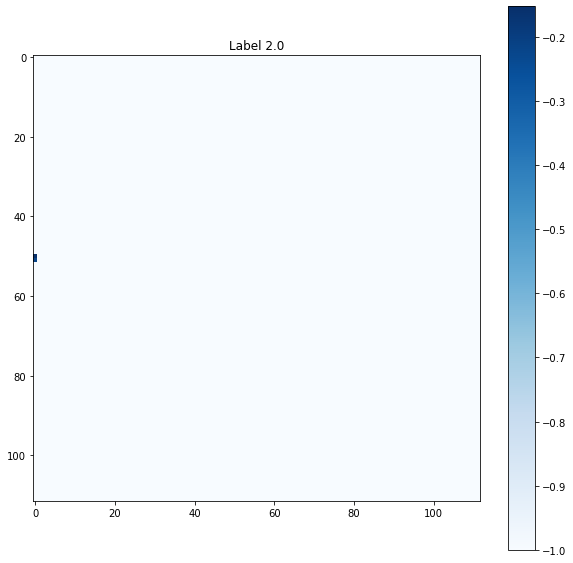

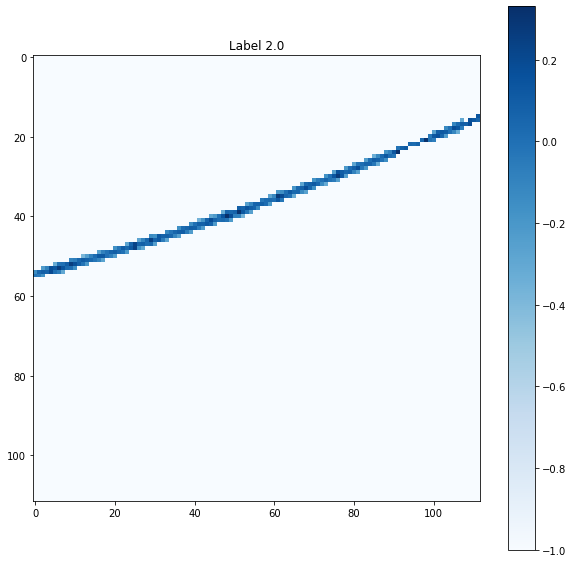

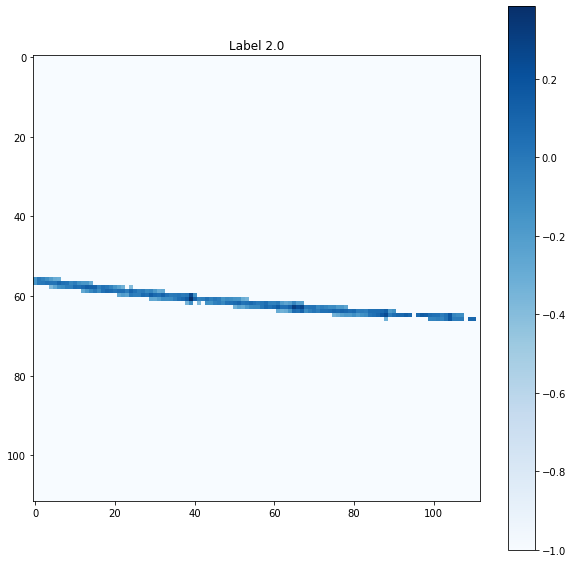

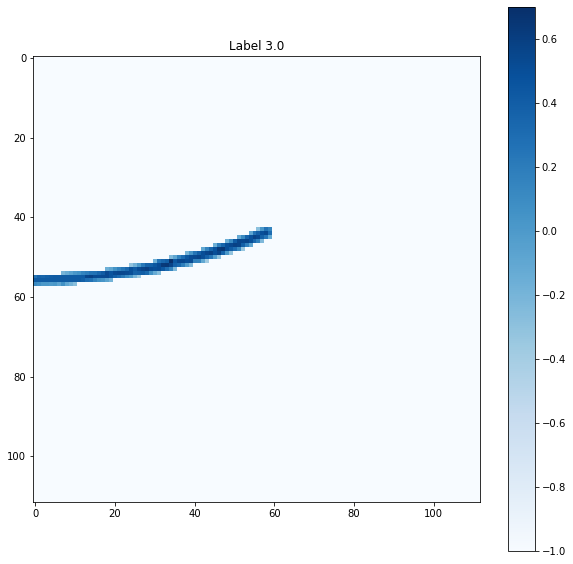

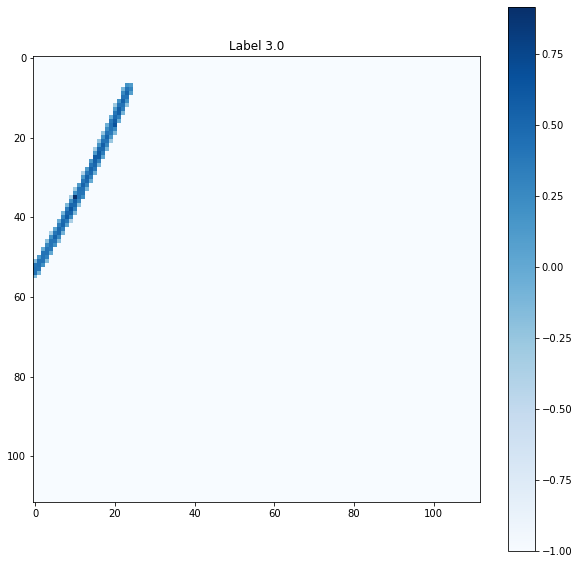

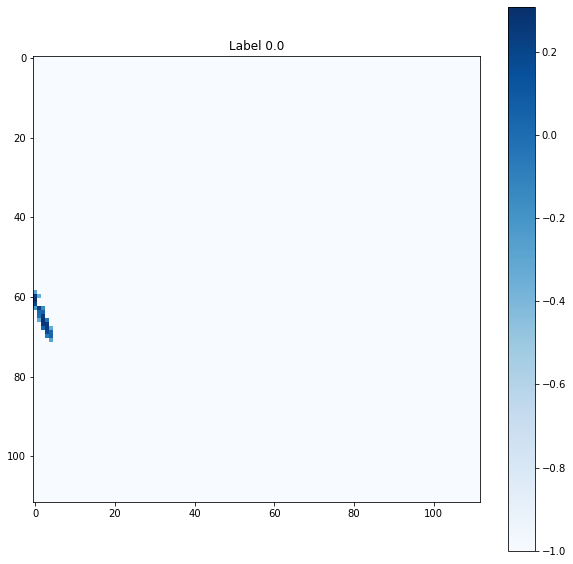

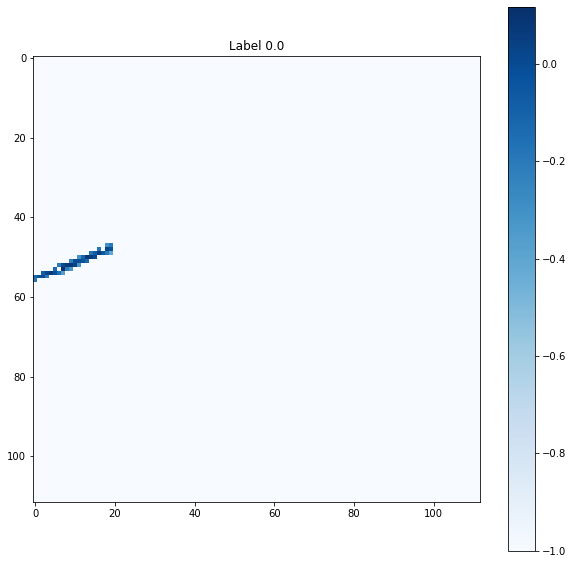

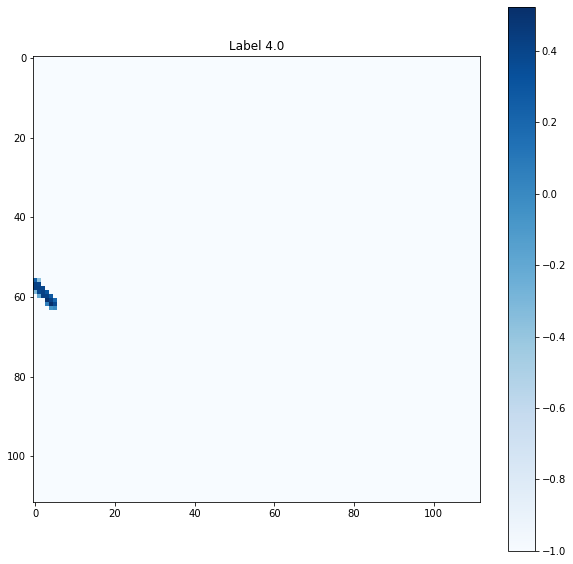

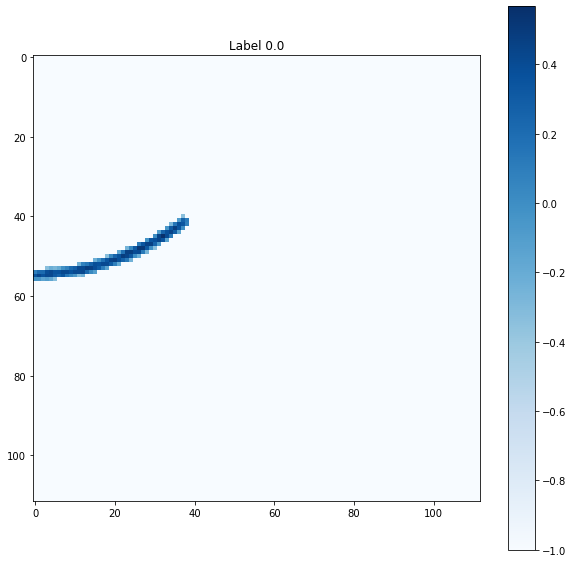

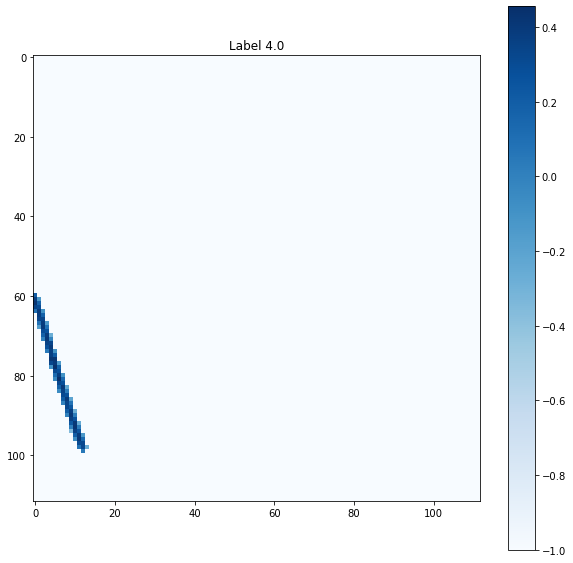

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [6]:
for i in range(10):
    title = train_target[i]
    plt.figure(figsize = (10,10))
    plt.title("Label {}".format(title))
    plt.imshow(train_input[i], cmap='Blues')
    plt.colorbar()
    plt.show()
print(train_input[0])

### Expand Dimensions: 

Typically, CNN models expect to see three color channels, but we do not have that distinction for our data. Hence, we will just expand the dimensions of our data, essentially creating three layers of the data we already have. The CNN will then accept our input data as a correct form of input. 

In [7]:
print(train_input[0])
print('------------------')
train_input = np.expand_dims(train_input, axis=3)
print(train_input[0])
print('------------------')
train_input = np.repeat(train_input, 3, axis=3)
print(train_input[0])
print('------------------')

val_input = np.expand_dims(val_input, axis=3)
val_input = np.repeat(val_input, 3, axis=3)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
------------------
[[[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]]
------------------
[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1.

### Plotting the distributions of the Labels of Test Set and Training Set

It's good to know how many input images you will put into the model:

In [8]:
len_train_input = len(train_input[0][0])
print(len_train_input)

112


Here we plot the distribution of the training input data:

(array([2.06593884e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.50900000e+03, 1.20900000e+04, 1.88310000e+04,
        2.43480000e+04, 3.04200000e+04, 3.41820000e+04, 3.82410000e+04,
        4.05030000e+04, 4.31970000e+04, 4.54260000e+04, 4.76910000e+04,
        4.91970000e+04, 5.13480000e+04, 5.31150000e+04, 5.56890000e+04,
        5.88030000e+04, 6.26490000e+04, 6.55890000e+04, 6.94830000e+04,
        7.25100000e+04, 7.67280000e+04, 7.79430000e+04, 7.81230000e+04,
        7.68810000e+04, 7.35510000e+04, 6.96300000e+04, 6.501300

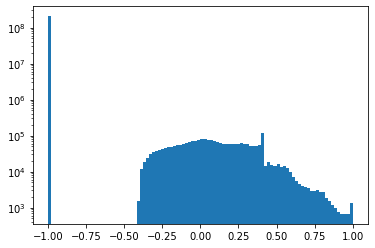

In [9]:
plt.hist(train_input.reshape(len(train_input)*112*112*3),bins=100, log=True)

Here we plot the distributions of the targets for both the validation and training sets: 
We should see a pretty even distibution of the targets over the particles. 

(array([276.,   0., 282.,   0.,   0., 303.,   0., 274.,   0., 257.]),
 array([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004,
        2.8000000000000003, 3.2, 3.6, 4.0], dtype=object),
 <a list of 10 Patch objects>)

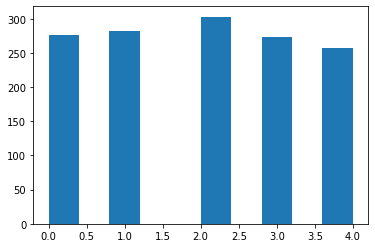

In [10]:
plt.hist(val_target)

(array([1141.,    0., 1104.,    0.,    0., 1140.,    0., 1106.,    0.,
        1065.]),
 array([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004,
        2.8000000000000003, 3.2, 3.6, 4.0], dtype=object),
 <a list of 10 Patch objects>)

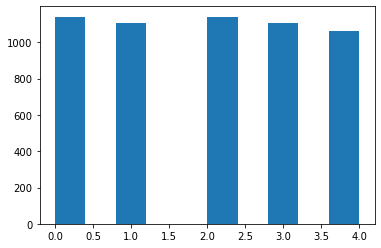

In [11]:
plt.hist(train_target)

### One Hot Encoding

It is important to one hot encode your training targets because this is the only way that a multiclass model can appropriately classify inputs. We use the sklearn one hot encoder for this:

In [12]:
enc = OneHotEncoder()

one_hot_encoding_train_target = train_target.reshape(len(train_input),1)
print(one_hot_encoding_train_target.shape)
X = [[0], [1], [2], [3], [4]]
# X = [['Proton', 0], ['Deuteron', 1], ['Triton', 2], ['He3', 3], ['He4', 4]]

enc.fit(X)
enc.categories_
one_hot_encoding_train_target = enc.transform(one_hot_encoding_train_target).toarray()
print(one_hot_encoding_train_target)

(5556, 1)
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


Verifying the one hot encoder:

In [13]:
zero = np.array([1.0,0.0,0.0,0.0,0.0])
one = np.array([0.0,1.0,0.0,0.0,0.0])
two = np.array([0.0,0.0,1.0,0.0,0.0])
three = np.array([0.0,0.0,0.0,1.0,0.0])
four = np.array([0.0,0.0,0.0,0.0,1.0])
my_dict = {0.0:zero, 1.0:one, 2.0: two, 3.0:three, 4.0: four}
index = 0
count = 0
for i in one_hot_encoding_train_target:
    if (i[0] != my_dict[train_target[index]][0] or 
                       i[1] != my_dict[train_target[index]][1] or
                       i[2] != my_dict[train_target[index]][2] or
                       i[3] != my_dict[train_target[index]][3] or
                       i[4] != my_dict[train_target[index]][4]):
        count += 1
    index += 1

print("If print is 0, then the one hot encoding is correct:")
print(count)


If print is 0, then the one hot encoding is correct:
0


Make sure there are actually five targets in our training targets set. 

In [24]:
print(len(np.unique(train_target))) #this should be 5
print(one_hot_encoding_train_target)

5
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [20]:
print(train_input[0])

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


### Making the Neural Network

Note that we are doing transfer learning. So we take a CNN that has already been trained then append a fully connected neural network on top of it that will learn to classify our images in particular after having been sent through the pre-trained CNN. 

In [21]:
# Determine the number of class labels
num_classes = len(np.unique(train_target)) #should be 5
print(len(np.unique(train_target)))
input_shape = (112,112,3)

def build_pretrained_vgg_model():
    """Constructs a CNN with a VGG16's convolutional base and two fully-connected hidden layers on top.
    The convolutional base is frozen (the weights can't be updated) and has weights from training on
    the ImageNet dataset.
    
    Returns:
        The model.
    """
    # This loads the VGG16 model from TensorFlow with ImageNet weights
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # First we flatten out the features from the VGG16 model
    net = tf.keras.layers.Flatten()(vgg_model.output)

    # We create a new fully-connected layer that takes the flattened features as its input
    net = tf.keras.layers.Dense(512, activation=tf.nn.relu)(net)
    # And we add one more hidden layer
    net = tf.keras.layers.Dense(512, activation=tf.nn.relu)(net)

    # Then we add a final layer which is connected to the previous layer and
    # groups our images into one of the three classes
    output = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)(net)

    # Finally, we create a new model whose input is that of the VGG16 model and whose output
    # is the final new layer we just created
    model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
    
    # We loop through all layers except the last four and specify that we do not want 
    # their weights to be updated during training. Again, the weights of the convolutional
    # layers have already been trained for general-purpose feature extraction, and we only
    # want to update the fully-connected layers that we just added.
    for layer in model.layers[:-1]:
        layer.trainable = False
    print(len(model.layers))
    return model

5


Here we call on the build model method and set our learning rate and loss function and learning metrics. 

In [76]:
model = build_pretrained_vgg_model()

model.compile(tf.keras.optimizers.Adam(lr=0.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

23


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

### Prepare the Callbacks:

In [89]:
# This is the directory where model weights will be saved. Feel free to change it.
CHECKPOINT_DIR = './log-model-checkpoints-402-pretrained-1'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# The checkpoints will be saved with the corresponding epoch number in their filename
ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{epoch:02d}')

# Setup checkpoint callback. We only save the weights, not the entire model
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True)

In [49]:
#here's a call back that reduces the learning rate when the model's
#accuracy starts to plateau. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau("val_accuracy", 
                                                 factor=0.5, patience=3, min_lr = 0.00000001, mode="min") 

Put all callbacks into one list for easy entry into the model.fit function:

In [50]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5),
    ckpt_callback,
    reduce_lr
]

We will also want to save an image of our learning curve from when the model gets trained:
Make sure to name your files appropriately keeping in mind whether you power transformed or log scaled. 

In [21]:
LEARNING_CURVE_DIR = "./LearningCurves"

if not os.path.exists(LEARNING_CURVE_DIR):
    os.makedirs(LEARNING_CURVE_DIR)

#want to save figure with the data and time.
#change to log_scale or power_transform accordingly:
today_time = str(datetime.today())
file_name = "log_scale_LC{}{}".format(today_time,'.png')
#file_name = "power_transform_LC{}".format(today_time,'.png')

save_fig_path = os.path.join(LEARNING_CURVE_DIR, file_name)

def plot_learning_curve(history):
    plt.plot(history["loss"], label="training loss")
    plt.plot(history["val_loss"], label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.legend()
    plt.savefig(save_fig_path, format='png')
    plt.show()
    


### Fit the Model 

In [ ]:
results = model.fit(train_input,
          one_hot_encoding_train_target,
          batch_size=32,
          epochs=100,
          validation_split=0.2,
          callbacks=my_callbacks);

plot_learning_curve(results.history)

2022-03-23 22:04:55.524196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-23 22:04:55.536229: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/100
139/139 [==============================] - 725s 5s/step - loss: 1.5811 - accuracy: 0.2645 - val_loss: 1.4279 - val_accuracy: 0.3480
Epoch 2/100
  2/139 [..............................] - ETA: 9:29 - loss: 1.3793 - accuracy: 0.4297

### Making Predictions and Plotting Confusion Matrix

Due to some of our callbacks, the model got saved after each epoch, so we can choose which epoch to test on. A good epoch to choose is the one where the validation loss started to seperate from the training loss. 

In [90]:
EARLY_STOPPING_EPOCH = 12

assert EARLY_STOPPING_EPOCH > 0, 'You need to set an early stopping point!'

# Path the the checkpoint we want to load
es_ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{:02d}'.format(EARLY_STOPPING_EPOCH))
model_path =  os.path.join(CHECKPOINT_DIR, 'saved_model.pb')
# Load the weights from the desired checkpoint into the model
model = tf.keras.models.load_model(CHECKPOINT_DIR)
model.load_weights(es_ckpt_path);

Here we make predictions on our validation set.

In [91]:
predictions = model.predict(val_input)

In [92]:
print(predictions[1])

[0.19990589 0.21146925 0.26053947 0.15900064 0.1690847 ]


predictions is currently a probability distribution, so we take the index from that distribution with the highest probability:

In [93]:
predictions = np.argmax(predictions, axis=1)

In [94]:
print(type(val_target))
print(type(val_target[1]))

<class 'numpy.ndarray'>
<class 'numpy.float64'>


Each element of val_target must be of type "numpy.float64", otherwise the confusion matrix code will break. 

In [95]:
val_target = val_target.astype(np.float64)

There are two main types of normalization for confusion matrices. Precision and recall. Choose whichever one you want. If you want Precision, choose normalize= 'pred', and for recall choose normalize= 'true'. 

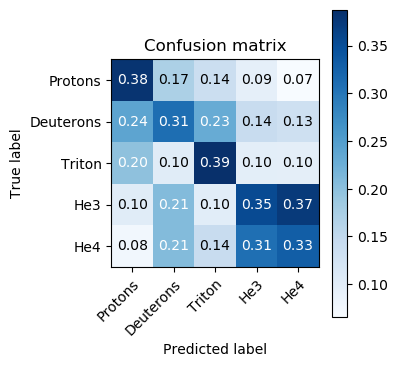

In [96]:
normalize='pred'

confusion = confusion_matrix(val_target, predictions, normalize=normalize)

plot_confusion_matrix_normalized(val_target, predictions, ["Protons", "Deuterons", "Triton","He3", "He4"], confusion)

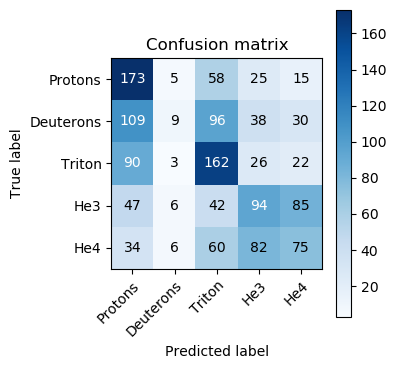

In [97]:
plot_confusion_matrix_augmented(val_target, predictions, ["Protons", "Deuterons", "Triton","He3", "He4"])